In [103]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
from scipy.fftpack import fft, fftshift, ifft
import seaborn as sns
from collections import Counter
import pandas as pd

### Check raw data(Sinogram)

In [104]:
sinogram_path = "Data/sinogram.npy"

In [105]:
sinogram = np.load(sinogram_path)
sinogram_data, sinogram_n = sinogram.shape
print("projection number(degree): ", sinogram_n)
print("projection data: ", sinogram_data)

projection number(degree):  180
projection data:  512


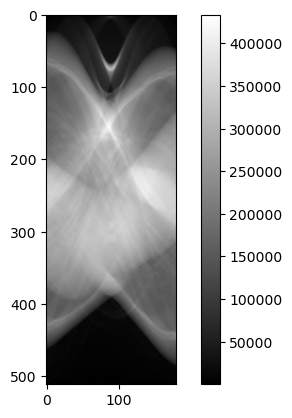

In [106]:
plt.imshow(sinogram, cmap='gray')
plt.colorbar()
plt.show()

### Setting metadata
- setting image parameters

In [107]:
# 512px * 512px
nx = 512
ny = 512

# 2mm pixel
dx = 2

# 180 projections
nr = 180
dr = 1

### Compute 0th moment
- gathering sinogram's 0th column = projection data

In [108]:
i = 0

In [109]:
projection_i = sinogram[:, i]
print(projection_i.shape)

(512,)


- need to reshape for calculation

In [110]:
projection_i = np.reshape(sinogram[:, i], (1, nx))
print(projection_i.shape)

(1, 512)


In [111]:
one_sinogram = np.zeros((nx, ny))

In [112]:
projection_i_smear = np.tile(projection_i, (nx,1))
rot = rotate(projection_i_smear, i, reshape=False)
one_sinogram += rot

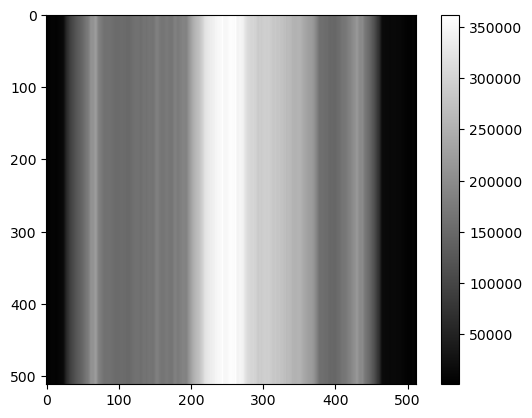

In [113]:
plt.imshow(one_sinogram, cmap='gray')
plt.colorbar()
plt.show()

### Backprojection summation

In [114]:
image_with_filter = np.zeros((nx, ny))
image_no_filter = np.zeros((nx, ny))
print(image_no_filter.shape)

(512, 512)


- since we gather data base on dr 1 degree

In [115]:
def sum_backprojection(sinogram, nr, dr, output):
    for i in range(0,nr,dr):
        projection_i = np.reshape(sinogram[:, i], (1,nx))
        print(f"angle {i} of {nr}: ")
        projection_i_smear = np.tile(projection_i, (nx,1))
        rot_i = rotate(projection_i_smear, i, reshape=False)
        output+= rot_i
    return  output

In [116]:
image_no_filter = sum_backprojection(sinogram, nr, dr, image_no_filter)

angle 0 of 180: 
angle 1 of 180: 
angle 2 of 180: 
angle 3 of 180: 
angle 4 of 180: 
angle 5 of 180: 
angle 6 of 180: 
angle 7 of 180: 
angle 8 of 180: 
angle 9 of 180: 
angle 10 of 180: 
angle 11 of 180: 
angle 12 of 180: 
angle 13 of 180: 
angle 14 of 180: 
angle 15 of 180: 
angle 16 of 180: 
angle 17 of 180: 
angle 18 of 180: 
angle 19 of 180: 
angle 20 of 180: 
angle 21 of 180: 
angle 22 of 180: 
angle 23 of 180: 
angle 24 of 180: 
angle 25 of 180: 
angle 26 of 180: 
angle 27 of 180: 
angle 28 of 180: 
angle 29 of 180: 
angle 30 of 180: 
angle 31 of 180: 
angle 32 of 180: 
angle 33 of 180: 
angle 34 of 180: 
angle 35 of 180: 
angle 36 of 180: 
angle 37 of 180: 
angle 38 of 180: 
angle 39 of 180: 
angle 40 of 180: 
angle 41 of 180: 
angle 42 of 180: 
angle 43 of 180: 
angle 44 of 180: 
angle 45 of 180: 
angle 46 of 180: 
angle 47 of 180: 
angle 48 of 180: 
angle 49 of 180: 
angle 50 of 180: 
angle 51 of 180: 
angle 52 of 180: 
angle 53 of 180: 
angle 54 of 180: 
angle 55 of 180: 
an

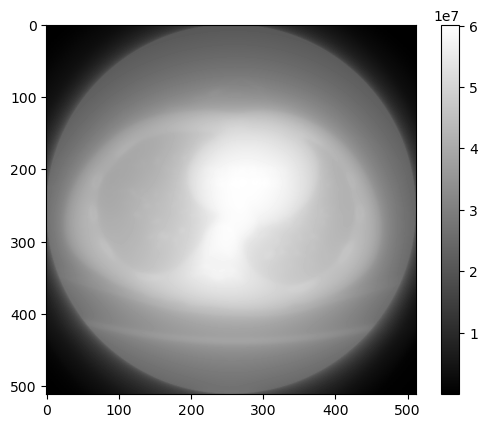

In [117]:
plt.imshow(image_no_filter, cmap='gray')
plt.colorbar()
plt.show()

- need to check range and know filter
    - to long so prefer not to run

In [118]:
# data_cut = np.round(image_no_filter, 2).flatten()
# data_cut = Counter(data_cut)

# df = pd.DataFrame.from_dict(data_cut, orient='index').reset_index()
# df.columns = ['Element', 'Count']
# sns.barplot(x='Element', y='Count', data=df)

# plt.show()

![countplot](./Data/countplot.png)

In [119]:
print(image_no_filter.max(), image_no_filter.min())

60143533.1587036 1438.162196361637


- cliping_1

In [120]:
image_no_filter_30000000 = np.clip(image_no_filter, a_min=30000000, a_max=None)
print(image_no_filter_30000000.max(), image_no_filter_30000000.min())

60143533.1587036 30000000.0


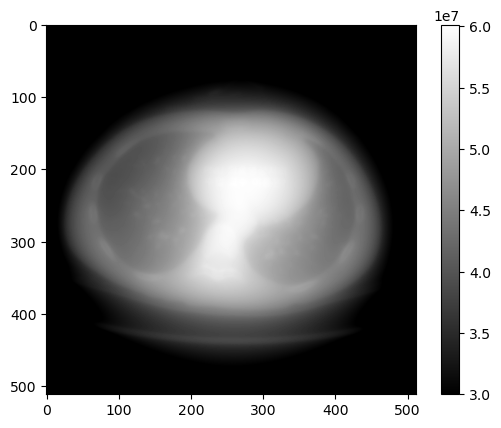

In [121]:
plt.imshow(image_no_filter_30000000, cmap='gray')
plt.colorbar()
plt.show()

- cliping2
    - cliping for showing question

In [122]:
image_no_filter_question = np.clip(image_no_filter, a_min=55000000, a_max=60000000)
print(image_no_filter_question.max(), image_no_filter_question.min())

60000000.0 55000000.0


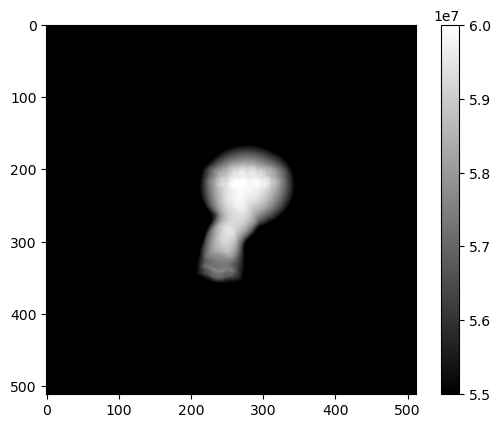

In [123]:
plt.imshow(image_no_filter_question, cmap='gray')
plt.colorbar()
plt.show()

- 숨은 question: PNU 의료영상처리 수업 교수 이름은?: 김민우 교수님

### FBP algorithm
- fft, fftshift to center low frequecy

- RamLak Filter

In [124]:
def ram_lak_filter(n):
    filter_out = np.zeros(n)
    
    inc = (2*np.pi)/(n-n%2)
    offset  = 0

    for i in range(n):
        if n%2 ==0 and i == n/2:
            offset = 1
        filter_out[i] = abs(-1*np.pi + inc *(i+offset))
        
    return filter_out

In [125]:
FT_q = fftshift(ram_lak_filter(sinogram_n))
print(FT_q.shape)

(180,)


In [126]:
filtered_sinogram = np.zeros((sinogram_data, sinogram_n))

In [127]:
for i in range(sinogram_data):
    sinogram_row = sinogram[i]
    FT_p = fft(sinogram_row)
    filtered = np.real(ifft(FT_p * FT_q))
    filtered_sinogram[i] = filtered

In [128]:
filtered_sinogram.shape


(512, 180)

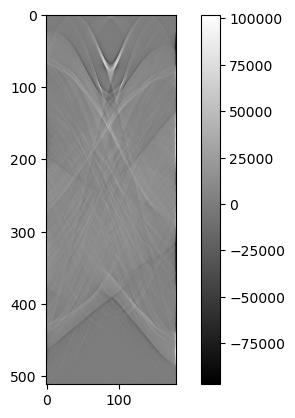

In [138]:
plt.imshow(filtered_sinogram, cmap='gray')
plt.colorbar()
plt.show()

In [129]:
image_with_filter = sum_backprojection(filtered_sinogram, nr, dr, image_with_filter)

angle 0 of 180: 
angle 1 of 180: 
angle 2 of 180: 
angle 3 of 180: 
angle 4 of 180: 
angle 5 of 180: 
angle 6 of 180: 
angle 7 of 180: 
angle 8 of 180: 
angle 9 of 180: 
angle 10 of 180: 
angle 11 of 180: 
angle 12 of 180: 
angle 13 of 180: 
angle 14 of 180: 
angle 15 of 180: 
angle 16 of 180: 
angle 17 of 180: 
angle 18 of 180: 
angle 19 of 180: 
angle 20 of 180: 
angle 21 of 180: 
angle 22 of 180: 
angle 23 of 180: 
angle 24 of 180: 
angle 25 of 180: 
angle 26 of 180: 
angle 27 of 180: 
angle 28 of 180: 
angle 29 of 180: 
angle 30 of 180: 
angle 31 of 180: 
angle 32 of 180: 
angle 33 of 180: 
angle 34 of 180: 
angle 35 of 180: 
angle 36 of 180: 
angle 37 of 180: 
angle 38 of 180: 
angle 39 of 180: 
angle 40 of 180: 
angle 41 of 180: 
angle 42 of 180: 
angle 43 of 180: 
angle 44 of 180: 
angle 45 of 180: 
angle 46 of 180: 
angle 47 of 180: 
angle 48 of 180: 
angle 49 of 180: 
angle 50 of 180: 
angle 51 of 180: 
angle 52 of 180: 
angle 53 of 180: 
angle 54 of 180: 
angle 55 of 180: 
an

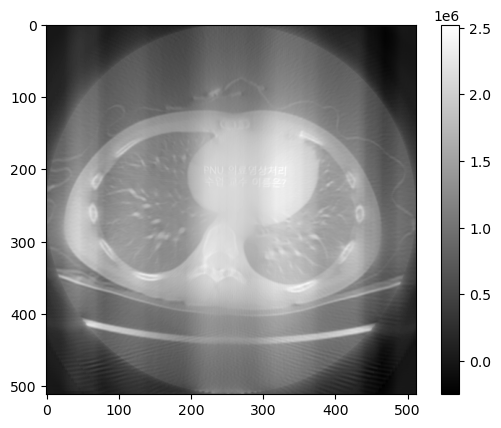

In [130]:
plt.imshow(image_with_filter, cmap='gray')
plt.colorbar()
plt.show()

### Testing dr more sparse

In [131]:
image_with_filter_10 = np.zeros((nx, ny))
image_with_filter_30 = np.zeros((nx, ny))
image_with_filter_60 = np.zeros((nx, ny))

In [132]:
image_with_filter_10 = sum_backprojection(filtered_sinogram, nr, 18, image_with_filter_10)

angle 0 of 180: 
angle 18 of 180: 
angle 36 of 180: 
angle 54 of 180: 
angle 72 of 180: 
angle 90 of 180: 
angle 108 of 180: 
angle 126 of 180: 
angle 144 of 180: 
angle 162 of 180: 


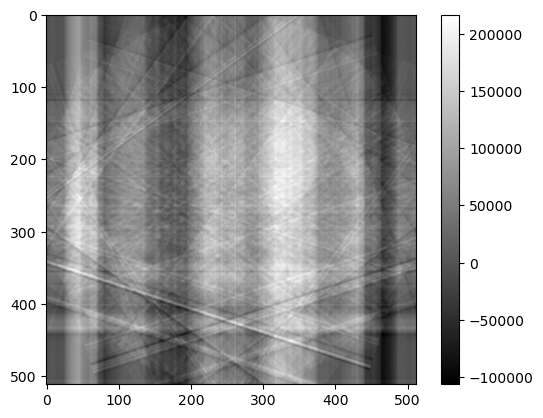

In [133]:
plt.imshow(image_with_filter_10, cmap='gray')
plt.colorbar()
plt.show()

In [134]:
image_with_filter_30 = sum_backprojection(filtered_sinogram, nr, 6, image_with_filter_30)

angle 0 of 180: 
angle 6 of 180: 
angle 12 of 180: 
angle 18 of 180: 
angle 24 of 180: 
angle 30 of 180: 
angle 36 of 180: 
angle 42 of 180: 
angle 48 of 180: 
angle 54 of 180: 
angle 60 of 180: 
angle 66 of 180: 
angle 72 of 180: 
angle 78 of 180: 
angle 84 of 180: 
angle 90 of 180: 
angle 96 of 180: 
angle 102 of 180: 
angle 108 of 180: 
angle 114 of 180: 
angle 120 of 180: 
angle 126 of 180: 
angle 132 of 180: 
angle 138 of 180: 
angle 144 of 180: 
angle 150 of 180: 
angle 156 of 180: 
angle 162 of 180: 
angle 168 of 180: 
angle 174 of 180: 


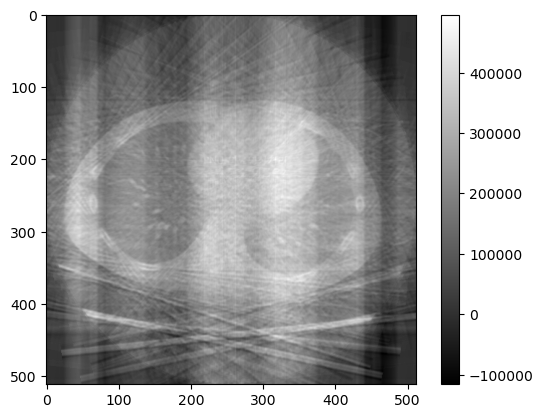

In [135]:
plt.imshow(image_with_filter_30, cmap='gray')
plt.colorbar()
plt.show()

In [136]:
image_with_filter_60 = sum_backprojection(filtered_sinogram, nr, 3, image_with_filter_60)

angle 0 of 180: 
angle 3 of 180: 
angle 6 of 180: 
angle 9 of 180: 
angle 12 of 180: 
angle 15 of 180: 
angle 18 of 180: 
angle 21 of 180: 
angle 24 of 180: 
angle 27 of 180: 
angle 30 of 180: 
angle 33 of 180: 
angle 36 of 180: 
angle 39 of 180: 
angle 42 of 180: 
angle 45 of 180: 
angle 48 of 180: 
angle 51 of 180: 
angle 54 of 180: 
angle 57 of 180: 
angle 60 of 180: 
angle 63 of 180: 
angle 66 of 180: 
angle 69 of 180: 
angle 72 of 180: 
angle 75 of 180: 
angle 78 of 180: 
angle 81 of 180: 
angle 84 of 180: 
angle 87 of 180: 
angle 90 of 180: 
angle 93 of 180: 
angle 96 of 180: 
angle 99 of 180: 
angle 102 of 180: 
angle 105 of 180: 
angle 108 of 180: 
angle 111 of 180: 
angle 114 of 180: 
angle 117 of 180: 
angle 120 of 180: 
angle 123 of 180: 
angle 126 of 180: 
angle 129 of 180: 
angle 132 of 180: 
angle 135 of 180: 
angle 138 of 180: 
angle 141 of 180: 
angle 144 of 180: 
angle 147 of 180: 
angle 150 of 180: 
angle 153 of 180: 
angle 156 of 180: 
angle 159 of 180: 
angle 162 of

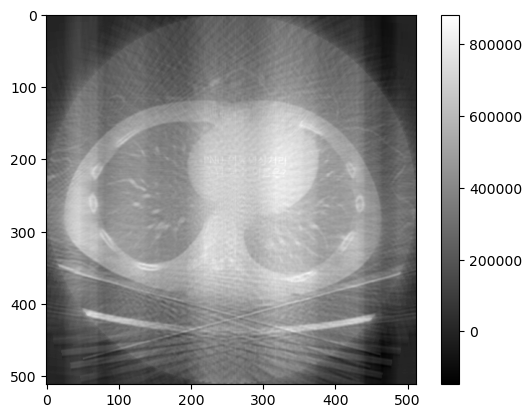

In [137]:
plt.imshow(image_with_filter_60, cmap='gray')
plt.colorbar()
plt.show()